Flex all X-axes joints of the robox.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, time
from os.path import dirname
sys.path.append(os.path.join(os.getcwd(), '..'))

In [3]:
import cv2
import pybullet as p
import numpy as np
import pylab

from opencv.opencv_tools import save
from pyb.pybullet_robot import PyBulletRobot
from opencv.opencv_pose import Pose
from phy.phy_robot import PhyRobot

In [9]:
def rodrigues_to_euler_angles(rvec):
        mat, jac = cv2.Rodrigues(rvec)

        sy = np.sqrt(mat[0, 0] * mat[0, 0] + mat[1, 0] * mat[1, 0])

        singular = sy < 1e-6

        if not singular:
            x = np.math.atan2(mat[2, 1], mat[2, 2])
            y = np.math.atan2(-mat[2, 0], sy)
            z = np.math.atan2(mat[1, 0], mat[0, 0])

        else:
            x = np.math.atan2(-mat[1, 2], mat[1, 1])
            y = np.math.atan2(-mat[2, 0], sy)
            z = 0

        return np.array([x, y, z])

In [4]:
vr = PyBulletRobot(render=False)

*** Initializing PyBulletRobot(ns=4, render=False) ...
*** Initializing PyBulletRobot() done


In [78]:
def phis_1x(phix):
    phis = np.array([[phix, 0], [phix, 0], [phix, 0], [phix, 0]])
    return phis

def vr_sweep():
    PHIX_LOW, PHIX_HIGH = 0.36, 0.4
    DPHI = (PHIX_HIGH - PHIX_LOW) / 25
    phixs = np.arange(PHIX_LOW, PHIX_HIGH+DPHI, DPHI)

    phiss, camps, tvecs, rvecs = [], [], [], []

    first_phi, last_phi = None, None
    vpose = Pose(vr.W, vr.H, '../pyb/cal.npz', vr.D)

    for phix in phixs:
        phis = phis_1x(phix)
        print(phis)
        vr.step(phis)
        img, cam_p, _, _, _ = vr.getHeadcam()

        #plt.figure()
        #plt.imshow(img)
        #plt.title(str(phixs))
        
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            camps.append(cam_p)
            tvecs.append(tvec)
            rvecs.append(rvec)
            phiss.append(phis)

            if first_phi is None:
                first_phi = last_phi = phix
                print("vr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix

            evec = rodrigues_to_euler_angles(rvec)
            print("evec1=%s" % evec[1])
            #if evec[1] > 0:
            #    break

    print("vr last_phi: %f" % last_phi)

    phiss = np.array(phiss)
    camps = np.array(camps)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, camps, tvecs, rvecs

## VR robot

In [77]:
phiss, camps, tvecs, rvecs = vr_sweep()

vr first_phi: 0.361600
evec1=-0.12309736673267407
evec1=-0.11573007818633624
evec1=-0.11086896044302946
evec1=-0.10795791788300178
evec1=-0.09894097128913723
evec1=-0.09055660260641211
evec1=-0.08570590442863962
evec1=-0.08078259903153975
evec1=-0.07505293996869364
evec1=-0.0661048466385121
evec1=-0.061153174332554995
evec1=-0.052897846281644435
evec1=-0.04460281728670569
evec1=-0.04221593926346601
evec1=-0.03426931412944778
evec1=-0.02857062370887724
evec1=-0.020923983782229018
evec1=-0.014482829457336215
evec1=-0.009224963937021392
evec1=-0.003279373104295161
evec1=0.004326417356829723
evec1=0.008489813072016955
evec1=0.014986804049041536
evec1=0.02379973641165715
vr last_phi: 0.398400


In [93]:
# distance from damera position to the center of the chessboard
camds = []
for cam_p in camps:
    cam_d = np.sqrt(np.sum(np.square(np.array(cam_p) - np.array([2, 0, 0.59])), axis=0))
    camds.append(cam_d)
camds = np.array(camds)

# length of the translation vector
tvecds = np.sqrt(np.sum(np.square(tvecs), axis=1)).ravel()

evecs=[]
for rvec in rvecs:
    evec = rodrigues_to_euler_angles(rvec)
    evecs.append(evec)
evecs=np.array(evecs)

#### head moves down on Z world axis

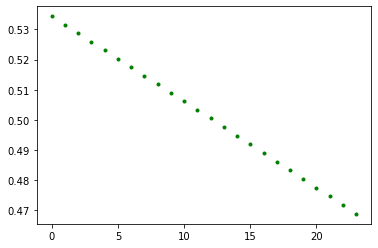

In [79]:
plt.plot(camps[:,2], 'g.')

#### target Y component of translation vector sweeps from 0.6 to -0.6

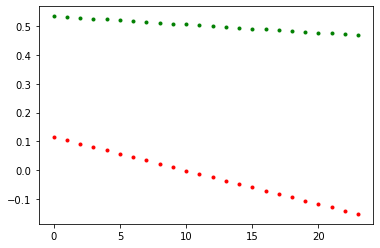

In [80]:
plt.plot(camps[:,2], 'g.', tvecs[:,1], 'r.')

#### headcam sways horizontally a tiny bit

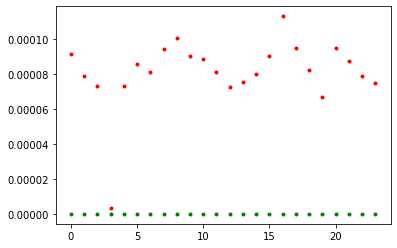

In [81]:
plt.plot(camps[:,1], 'g.', tvecs[:,0], 'r.')

#### headcam gets closer to the target

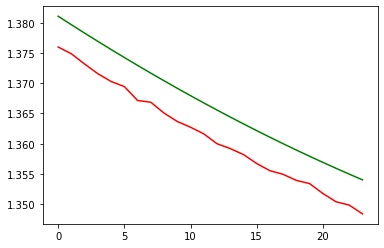

In [82]:
plt.plot(camds, 'g', tvecds, 'r')

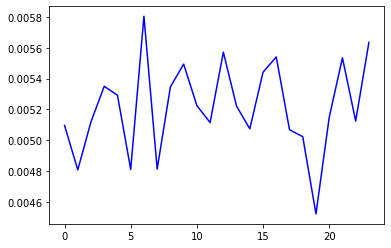

In [83]:
plt.plot(camds - tvecds, 'b')

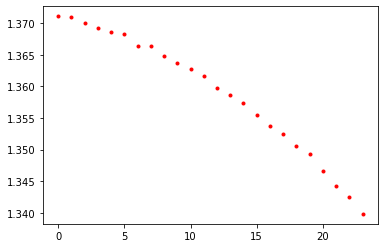

In [84]:
plt.plot(tvecs[:,2], 'r.')

#### Rotation vectors

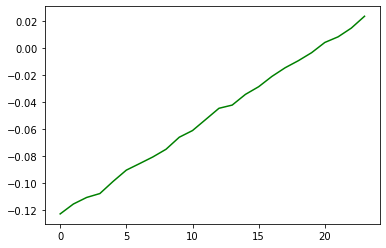

In [86]:
#_ = plt.plot(evecs[:,0], 'r', evecs[:,1], 'g', evecs[:,2], 'b', )
_ = plt.plot(evecs[:,1], 'g')

In [23]:
vr.close()

*** PyBulletRobot() closed ***


## Real Robot

In [104]:
rr = PhyRobot()

# ==== 
# COMPORT 1 port=COM3 desc=Arduino Mega 2560 (COM3) hwid=USB VID:PID=2341:0042 SER=5583834363335110D111 LOCATION=1-1.2
# + IDENTIFIED AS PORT2: COM3
# COMPORT 2 port=COM4 desc=Arduino Mega 2560 (COM4) hwid=USB VID:PID=2341:0042 SER=858303033393515190B0 LOCATION=1-1.1
# + IDENTIFIED AS PORT1: COM4
# + Found PORT1=COM4 PORT2=COM3
Current resolution: 640.0x480.0
New resolution: 1920.0x1080.0


In [105]:
def rr_sweep():
    PHIX_LOW, PHIX_HIGH = 0.22, 0.31
    DPHI = (PHIX_HIGH - PHIX_LOW) / 25
    phixs = np.arange(PHIX_LOW, PHIX_HIGH+DPHI, DPHI)

    phiss, tvecs, rvecs = [], [], []

    first_phi, last_phi = None, None
    vpose = Pose(rr.W, rr.H, '../phy/cal.npz', rr.D)

    first = True
    for phix in phixs:
        print("phix=%s" % phix)
        phis = phis_1x(phix)                  
        rr.step(phis)
        
        if first:
            time.sleep(5)
            first = False
        else:
            time.sleep(1)
        
        img, _, _, _, _ = rr.getHeadcam()
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            phiss.append(phis)
            rvecs.append(rvec)
            tvecs.append(tvec)

            if first_phi is None:
                first_phi = last_phi = phix
                print("rr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix
                
            evec = rodrigues_to_euler_angles(rvec)
            print("evec1=%s" % evec[1])
            #if evec[1] > 0:
            #    break

    print("rr last_phi: %s" % last_phi)

    phiss = np.array(phiss)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, tvecs, rvecs

In [106]:
r_phiss, r_tvecs, r_rvecs = rr_sweep()
r_tvecds = np.sqrt(np.sum(np.square(r_tvecs), axis=1)).ravel()

phix=0.22
phix=0.2236
phix=0.22719999999999999
phix=0.23079999999999998
phix=0.23439999999999997
phix=0.23799999999999996
phix=0.24159999999999995
phix=0.24519999999999995
phix=0.24879999999999994
phix=0.25239999999999996
phix=0.2559999999999999
phix=0.25959999999999994
rr first_phi: 0.259600
evec1=-0.17463022569890946
phix=0.2631999999999999
evec1=-0.1632373872633753
phix=0.2667999999999999
evec1=-0.15383840595896178
phix=0.27039999999999986
evec1=-0.14471766275280487
phix=0.2739999999999999
evec1=-0.13601441983000825
phix=0.27759999999999985
evec1=-0.12695814276872017
phix=0.2811999999999999
evec1=-0.11340044354223217
phix=0.28479999999999983
evec1=-0.10090220314945372
phix=0.2883999999999999
evec1=-0.09025164961029718
phix=0.2919999999999998
evec1=-0.08189543105399981
phix=0.29559999999999986
evec1=-0.07082156251604975
phix=0.2991999999999998
evec1=-0.05877458800147782
phix=0.30279999999999985
evec1=-0.047027903334363956
phix=0.3063999999999998
evec1=-0.036355510239940526
phix=0.309

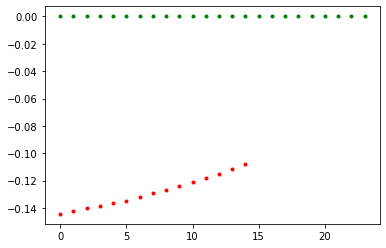

In [107]:
plt.plot(tvecs[:,0], 'g.', r_tvecs[:,0], 'r.')

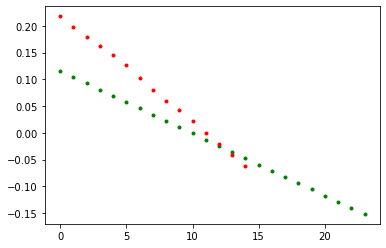

In [108]:
plt.plot(tvecs[:,1], 'g.', r_tvecs[:,1], 'r.')

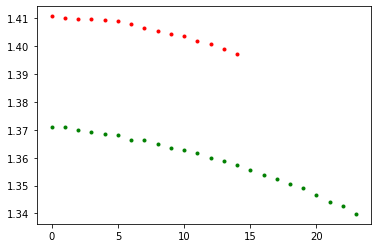

In [109]:
plt.plot(tvecs[:,2], 'g.', r_tvecs[:,2], 'r.')

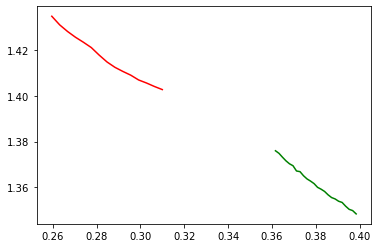

In [110]:
plt.plot(phiss[:,0,0], tvecds, 'g', r_phiss[:,0,0], r_tvecds, 'r', )

In [111]:
r_evecs=[]
for rvec in r_rvecs:
    evec = rodrigues_to_euler_angles(rvec)
    r_evecs.append(evec)
r_evecs=np.array(r_evecs)

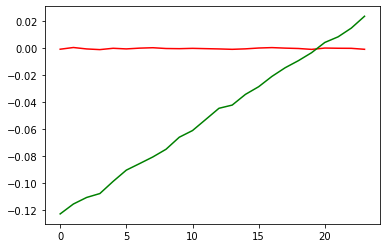

In [115]:
_ = plt.plot(evecs[:,0], 'r', evecs[:,1], 'g')

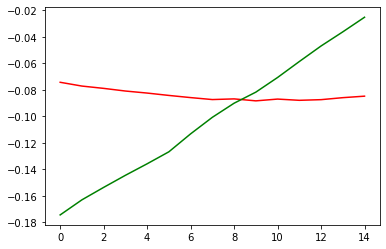

In [114]:
_ = plt.plot(r_evecs[:,0], 'r', r_evecs[:,1], 'g')

In [116]:
rr.home()
rr = None

In [94]:
img, _, _, _, _ = rr.getHeadcam()

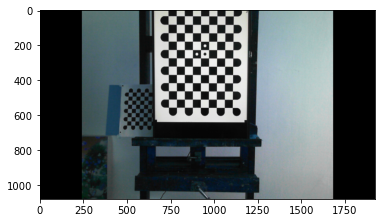

In [117]:
plt.imshow(img)